In [ ]:
import datetime

import matplotlib.pyplot as plt
import numpy as np
import shapely

from eolearn.core import EOPatch, FeatureType
from eolearn.features import NormalizedDifferenceIndexTask
from eolearn.io import SentinelHubInputTask
from sentinelhub import CRS, BBox, SentinelHubCatalog, SHConfig
from sentinelhub.data_collections import DataCollection
from sentinelhub.data_collections_bands import Band, Unit

## Overview

In [ ]:
config = SHConfig(profile="adv-demonstrator")
config.sh_base_url = "https://sh.dataspace.copernicus.eu"
config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
catalog = SentinelHubCatalog(config=config)

## Overview

This notebook demonstrates the integration and comparison of satellite and drone imagery for geospatial analysis. The workflow utilizes the SentinelHub API to access Copernicus Sentinel-2 satellite data and custom drone imagery (BYOC - Bring Your Own Collection) for the same geographical area of interest.

The analysis focuses on a specific polygon region in Greece (coordinates around 36.61°N, 23.02°E) and covers the time period from March to October 2024. The notebook showcases:

- **Multi-source data integration**: Combining Sentinel-2 L1C satellite imagery with high-resolution drone data
- **Temporal analysis**: Processing time-series data over a 7-month period
- **Spatial comparison**: Overlaying drone imagery on satellite imagery for enhanced visualization
- **Data processing pipeline**: Using EOLearn framework for efficient geospatial data handling

The workflow includes data acquisition, preprocessing, visualization, and the potential for advanced analysis such as NDVI computation and vegetation monitoring using both satellite and drone perspectives.

In [3]:
aoi = (
    "POLYGON ((23.023084 36.616195, 23.017994 36.616195, 23.017994 36.612681, 23.023084 36.612681, 23.023084"
    " 36.616195))"
)

In [4]:
aoi = shapely.wkt.loads(aoi)

In [5]:
eop = EOPatch(bbox=BBox(aoi.bounds, crs=CRS.WGS84))

In [6]:
s2l1c_collection = DataCollection.SENTINEL2_L1C
s2l1c_collection.service_url = config.sh_base_url


drone_collection = DataCollection.define_byoc(
    "e8d3e7b9-65e1-478f-9d2a-502c2d15b00c",
    bands=[
        Band(name="red", units=(Unit.DN,), output_types=(np.uint8,)),
        Band(name="green", units=(Unit.DN,), output_types=(np.uint8,)),
        Band(name="blue", units=(Unit.DN,), output_types=(np.uint8,)),
        Band(name="alpha", units=(Unit.DN,), output_types=(np.uint8,)),
    ],
    metabands=[Band(name="dataMask", units=(Unit.DN,), output_types=(bool,))],
)

In [7]:
input_satellite_task = SentinelHubInputTask(
    data_collection=s2l1c_collection,
    bands=["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B09", "B10", "B11", "B12"],
    bands_feature=(FeatureType.DATA, "BANDS"),
    additional_data=[(FeatureType.MASK, "dataMask")],
    resolution=0.5,
    maxcc=0.5,
    time_difference=datetime.timedelta(hours=2),
    config=config,
    max_threads=3,
)


input_drone_task = SentinelHubInputTask(
    data_collection=drone_collection,
    bands=["red", "green", "blue", "alpha"],
    bands_feature=(FeatureType.DATA, "BANDS"),
    additional_data=[(FeatureType.MASK, "dataMask")],
    resolution=0.5,
    time_difference=datetime.timedelta(hours=2),
    config=config,
    max_threads=3,
)
compute_ndvi = NormalizedDifferenceIndexTask(
    input_feature=(FeatureType.DATA, "BANDS"), output_feature=(FeatureType.DATA, "NDVI"), bands=(8, 4)
)

In [8]:
eop_sentinel = input_satellite_task.execute(
    eop.copy(deep=True), time_interval=(datetime.datetime(2024, 3, 1), datetime.datetime(2024, 10, 1))
)
eop_drone = input_drone_task.execute(
    eop.copy(), time_interval=(datetime.datetime(2024, 3, 1), datetime.datetime(2024, 10, 1))
)

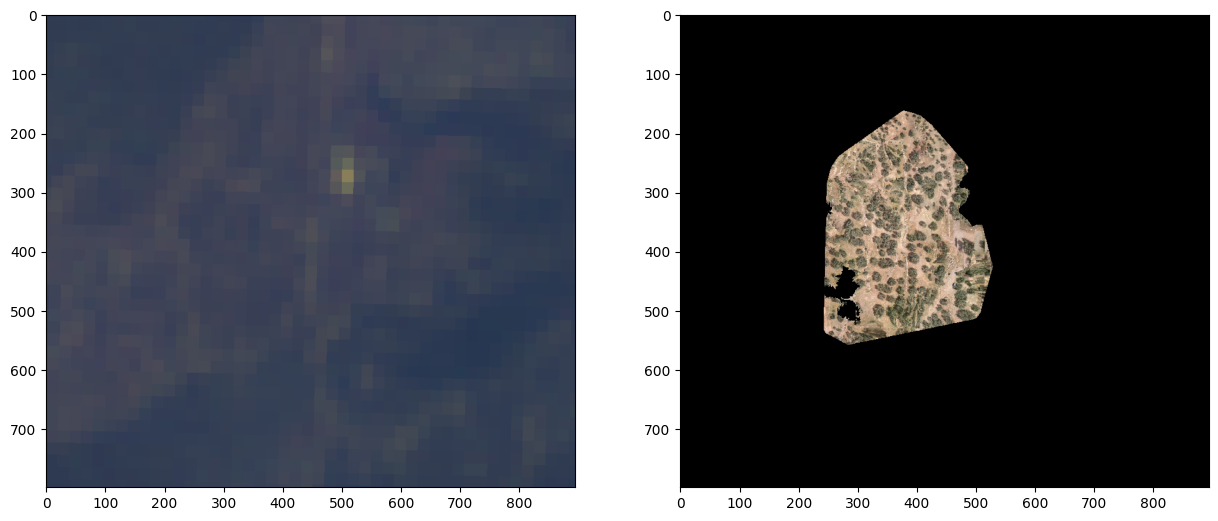

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(eop_sentinel.data["BANDS"][0][..., [2, 1, 0]] * 3)
ax[1].imshow(eop_drone.data["BANDS"][0][..., [0, 1, 2]] / 256)

(-0.5, 893.5, 798.5, -0.5)

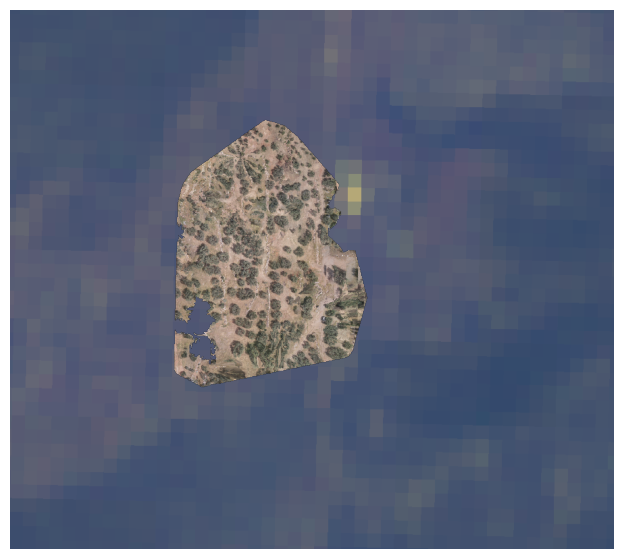

In [9]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.imshow(eop_sentinel.data["BANDS"][0][..., [2, 1, 0]] * 4)

drone_image = eop_drone.data["BANDS"][0][..., [0, 1, 2, 3]] / 256
drone_image[..., 3] = eop_drone.mask["dataMask"].astype(np.float64).squeeze()
drone_image[..., 3] = np.where(drone_image[..., 0] > 0, 1, 0)
ax.imshow(drone_image.astype(np.float32), alpha=0.8)
ax.axis("off")